In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

sns.set(style='whitegrid')  # Use seaborn for prettier plots


In [11]:
def load_path(path, part):
    """
    Load X-ray dataset based on the specified part.
    """
    dataset = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for body in os.listdir(folder_path):
                if body == part:
                    path_p = os.path.join(folder_path, body)
                    for patient_id in os.listdir(path_p):
                        path_id = os.path.join(path_p, patient_id)
                        for lab in os.listdir(path_id):
                            label = 'fractured' if lab.split('_')[-1] == 'positive' else 'normal'
                            path_l = os.path.join(path_id, lab)
                            for img in os.listdir(path_l):
                                img_path = os.path.join(path_l, img)
                                dataset.append({
                                    'body_part': body,
                                    'patient_id': patient_id,
                                    'label': label,
                                    'image_path': img_path
                                })
    return dataset


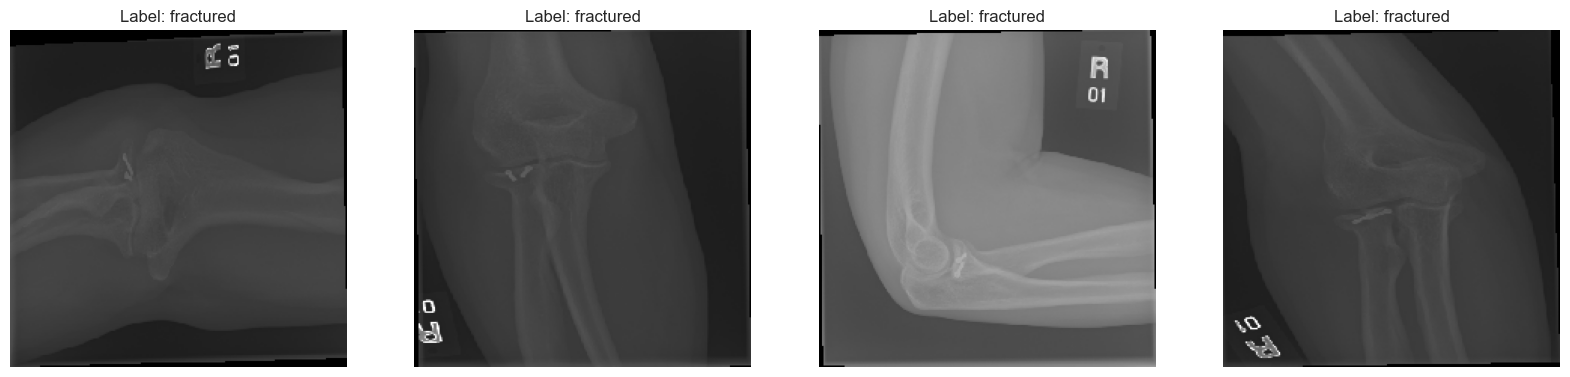

In [12]:
def visualize_samples(data, n=4):
    """
    Display sample images from the dataset with labels.
    """
    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    for i, row in enumerate(data[:n]):
        img = load_img(row['image_path'], target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {row['label']}")
    plt.show()

# Load a sample of 'Elbow' images and display
sample_data = load_path(os.path.join(os.getcwd(), 'Dataset'), 'Elbow')
visualize_samples(sample_data)


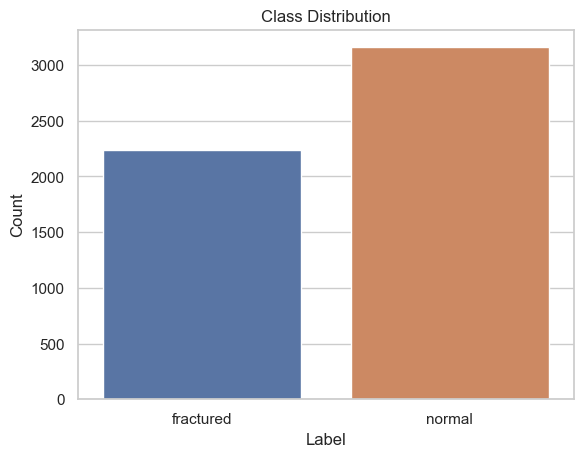

In [13]:
def visualize_class_distribution(data):
    """
    Display class distribution in the dataset.
    """
    df = pd.DataFrame(data)
    sns.countplot(x='label', data=df)
    plt.title('Class Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Visualize class distribution for 'Elbow' data
visualize_class_distribution(sample_data)


In [14]:
def trainPart(part):
    # Define paths
    THIS_FOLDER = os.getcwd()
    image_dir = os.path.join(THIS_FOLDER, 'Dataset')
    data = load_path(image_dir, part)

    # Prepare data for DataFrame
    labels = [row['label'] for row in data]
    filepaths = [row['image_path'] for row in data]

    images = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Split data: 90% train (80% train, 20% validation) and 10% test
    train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)

    # Data generators
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True, 
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        validation_split=0.2
    )

    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    # Load data into generators
    train_images = train_gen.flow_from_dataframe(
        train_df, x_col='Filepath', y_col='Label', target_size=(224, 224),
        class_mode='categorical', batch_size=64, subset='training', seed=42
    )

    val_images = train_gen.flow_from_dataframe(
        train_df, x_col='Filepath', y_col='Label', target_size=(224, 224),
        class_mode='categorical', batch_size=64, subset='validation', seed=42
    )

    test_images = test_gen.flow_from_dataframe(
        test_df, x_col='Filepath', y_col='Label', target_size=(224, 224),
        class_mode='categorical', batch_size=32, shuffle=False
    )

    # Define the ResNet50 model
    pretrained_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg'
    )
    pretrained_model.trainable = False

    # Add custom layers
    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(50, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_images, validation_data=val_images, epochs=25, callbacks=[callbacks])

    # Save the model
    model.save(os.path.join(THIS_FOLDER, f"weights/ResNet50_{part}_frac.h5"))

    # Evaluate and print test results
    results = model.evaluate(test_images, verbose=0)
    print(f"{part} Results: {results}")
    print(f"Test Accuracy: {np.round(results[1] * 100, 2)}%")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label


SyntaxError: incomplete input (3683225433.py, line 74)